<a href="https://colab.research.google.com/github/A-H-Sumon/FusionNet/blob/main/EfficientNet_B0_PrimaryDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 18.0 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 115.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 114.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import mixed_precision


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

# ======================== Directories and DataFrames ========================

from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("/content/drive/My Drive/dataset.csv", dtype=str)  # Ensure paths are read as strings

# Define features and labels
X = df["image_path"]  # Image paths
y = df["label"].astype(int)  # Labels as integers

# Split into 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Create DataFrames
train_df = pd.DataFrame({"image_path": X_train, "label": y_train})
test_df = pd.DataFrame({"image_path": X_test, "label": y_test})
#test_df.to_csv('/content/drive/MyDrive/test_df.csv', index=False)

print(f"Total training images: {len(train_df)}")
print(f"Total testing images: {len(test_df)}")

Total training images: 1672
Total testing images: 418


In [ ]:
# ======================== Data Preprocessing Function ========================
def preprocess_image(file_path):
    try:
        img = cv2.imread(file_path, cv2.IMREAD_COLOR)
        if img is None:
            raise ValueError(f"Image not found or unreadable: {file_path}")
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
        return img
    except Exception as e:
        print(f"Error processing image {file_path}: {e}")
        return np.zeros((224, 224, 3), dtype=np.uint8)  # Placeholder for missing/invalid images


In [ ]:
train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)



# ======================== Data Generators ========================
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',  # Include labels here
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',  # Ensure class mode is categorical
    shuffle=False
)

In [ ]:
import numpy as np
unique_labels, counts = np.unique(test_generator.labels, return_counts=True)
print(dict(zip(unique_labels, counts)))




{np.int64(0): np.int64(40), np.int64(1): np.int64(40), np.int64(2): np.int64(40), np.int64(3): np.int64(39), np.int64(4): np.int64(40), np.int64(5): np.int64(41), np.int64(6): np.int64(42), np.int64(7): np.int64(46), np.int64(8): np.int64(43), np.int64(9): np.int64(47)}


In [ ]:
print(test_df.head())  # Ensure 'label' column contains correct values


                                             image_path label
945   /content/drive/My Drive/dataset/4/0_CHAD_16_1_...     4
801   /content/drive/My Drive/dataset/4/0_B.BARIA_22...     4
1532  /content/drive/My Drive/dataset/7/0_CHAD_12_1_...     7
1677  /content/drive/My Drive/dataset/8/0_BAR_14_1_4...     8
1873  /content/drive/My Drive/dataset/9/0_BARG_10_1_...     9


In [ ]:
# ======================== EfficientNet-B0 Model ========================
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)#####ekhane edit
x = Dropout(0.3)(x)
output = Dense(len(train_df['label'].unique()), activation='softmax', dtype='float32')(x)


model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ======================== Callbacks ========================
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# ======================== Model Training ========================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 589s 7s/step - accuracy: 0.2798 - loss: 2.1557 - val_accuracy: 0.7096 - val_loss: 1.0855
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.6528 - loss: 1.1545 - val_accuracy: 0.8234 - val_loss: 0.6776
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.7258 - loss: 0.8362 - val_accuracy: 0.8713 - val_loss: 0.5329
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.8224 - loss: 0.6570 - val_accuracy: 0.8892 - val_loss: 0.4257
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.8247 - loss: 0.6121 - val_accuracy: 0.8922 - val_loss: 0.3746
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.8535 - loss: 0.4807 - val_accuracy: 0.8922 - val_loss: 0.3647
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.8659 - loss: 0.4490 - val_accuracy: 0.9222 - val_loss: 0.3125
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.8828 - loss: 0.3981 - val_accuracy: 0.8982 - v

In [ ]:
# ======================== Model Evaluation ========================
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

print("Test predictions completed.")

# Save the predictions
#np.save("/content/drive/MyDrive/test_predictions.npy", predicted_labels)


27/27 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step
Test predictions completed.


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Get true labels from the test generator
true_labels = test_generator.classes  # Ground truth
pred_labels = predicted_labels         # From your model's predictions

# Compute accuracy
acc = accuracy_score(true_labels, pred_labels)
print(f" Test Accuracy: {acc * 100:.2f}%")

# Compute classification report
target_names = list(test_generator.class_indices.keys())
print("\n📄 Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=target_names))


 Test Accuracy: 90.91%

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        40
           1       0.94      0.80      0.86        40
           2       0.95      0.95      0.95        40
           3       0.89      0.87      0.88        39
           4       0.95      0.90      0.92        40
           5       0.90      0.90      0.90        41
           6       0.88      0.90      0.89        42
           7       0.85      1.00      0.92        46
           8       0.93      0.95      0.94        43
           9       0.85      0.87      0.86        47

    accuracy                           0.91       418
   macro avg       0.91      0.91      0.91       418
weighted avg       0.91      0.91      0.91       418



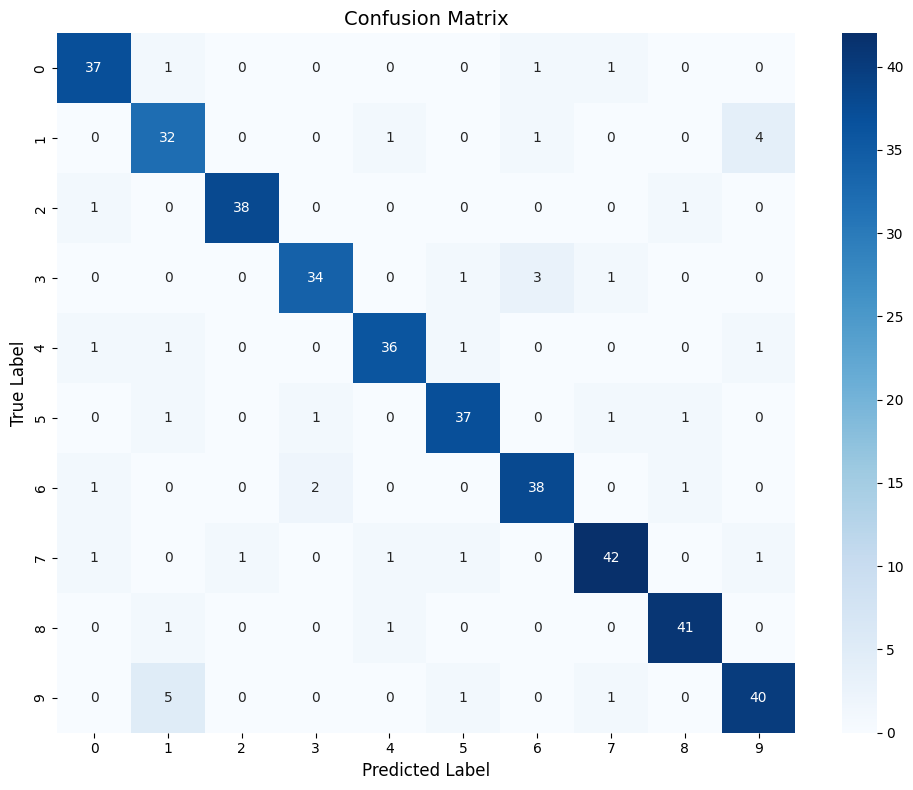

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
